# `CLOUD.jl` - 2D linear advection

In [53]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_dgmulti_2D/"
results_path = "../results/advection_dgmulti_2D/";

Define the physical problem

In [54]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);

Set up a quadrature-based DG scheme of degree `p` with `M` intervals in each direction

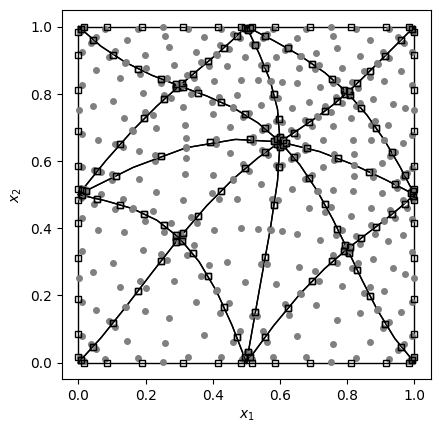

[-0.99999, -0.4999950000000001, 0.0, 0.4999950000000001, 0.99999][-1.0, -1.0, -1.0, -1.0, -1.0]
[-0.99999, -0.4999950000000001, -0.0, 0.4999950000000001, 0.99999][0.99999, 0.4999950000000001, 0.0, -0.4999950000000001, -0.99999]
[-1.0, -1.0, -1.0, -1.0, -1.0][-0.99999, -0.4999950000000001, -0.0, 0.4999950000000001, 0.99999]


In [55]:
M = 2  # number of elements
p = 5  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGMulti(p), Tri(), N_plot=ceil(Int,50/M), mapping_degree=p);
mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), collapsed=true), 
    reference_approximation.reference_element, 0.1)
spatial_discretization = SpatialDiscretization(mesh, reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, WeakConservationForm(), 
     (0.0, T), Lazy(), results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf")

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [56]:
reset_timer!()
n_s = 10
dt_scale=0.1
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            1.72s / 97.8%            542MiB / 99.2%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   1.26k    1.68s   100%  1.34ms    538MiB  100%    438KiB
   eval residual        20.1k    1.32s  78.2%  65.4μs    387MiB  71.9%  19.7KiB
     mass matrix solve  20.1k    650ms  38.6%  32.3μs   81.1MiB  15.1%  4.12KiB
     volume terms       20.1k    568ms  33.7%  28.2μs    292MiB  54.2%  14.8KiB
     facet terms        20.1k   11.1ms  0.66%   551ns   4.30MiB  0.80%     224B
   eval flux            20.1k   73.2ms  4.35%  3.64μs   24.9MiB  4.62%  1.27KiB
   gather external ...  20.1k   67.1ms 

Visualize the solution

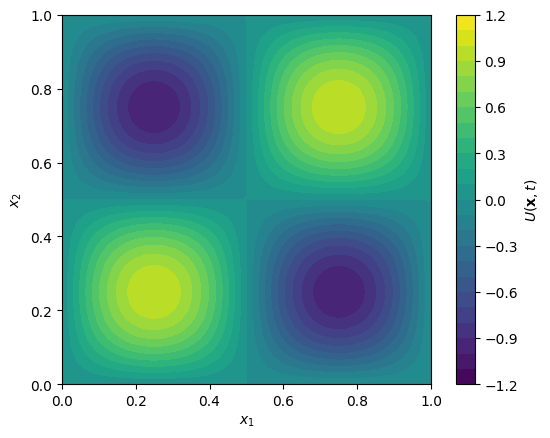

In [57]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

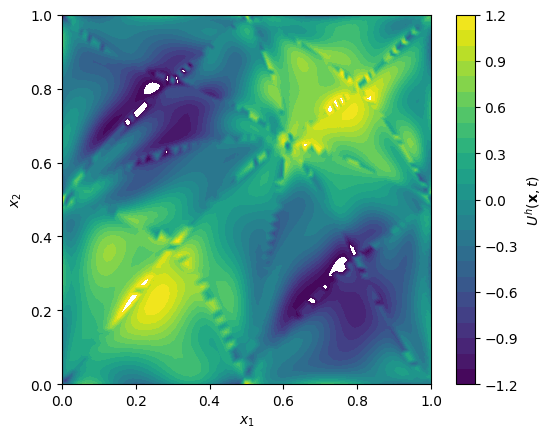

In [58]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, u_range=[-1.0,1.0],
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [59]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.17782954366476914]
Conservation (initial/final/diff):
[7.667208840739237e-8][7.667208884627741e-8][4.388850394221322e-16]
Energy (initial/final/diff):
[0.2499989325397254][0.281553902587709][0.031554970047983605]


In [60]:
check_sbp_property(reference_approximation)

(1.705857677336553e-13, 1.4854784069484595e-13)